https://keras.io/guides/transfer_learning/
An end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset
(half way down on the web page)

In [1]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import logging, os

logging.basicConfig(level=logging.INFO)
# logging.basicConfig(level=logging.DEBUG)

BASE_PATH = "../../../../local_data/jheaton/"
DATA_PATH = "../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"class_09_2_keras_xfer_cv/"
os.system("mkdir -p " + OUTPUT_PATH)

2025-06-25 21:28:41.479746: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 21:28:41.510045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


0

In [2]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    data_dir=DATA_PATH,
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

train_ds, validation_ds = tfds.load("cats_vs_dogs",
data_dir=DATA_PATH,
split=["train[:40%]", "train[40%:50%]"],as_supervised=True, )# Include labels

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

INFO:absl:Load dataset info from ../../../../local_data/tfds/cats_vs_dogs/4.0.0
INFO:absl:Reusing dataset cats_vs_dogs (../../../../local_data/tfds/cats_vs_dogs/4.0.0)
INFO:absl:Constructing tf.data.Dataset cats_vs_dogs for split ['train[:40%]', 'train[40%:50%]', 'train[50%:60%]'], from ../../../../local_data/tfds/cats_vs_dogs/4.0.0
INFO:absl:Load dataset info from ../../../../local_data/tfds/cats_vs_dogs/4.0.0
INFO:absl:Reusing dataset cats_vs_dogs (../../../../local_data/tfds/cats_vs_dogs/4.0.0)
INFO:absl:Constructing tf.data.Dataset cats_vs_dogs for split ['train[:40%]', 'train[40%:50%]'], from ../../../../local_data/tfds/cats_vs_dogs/4.0.0


Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


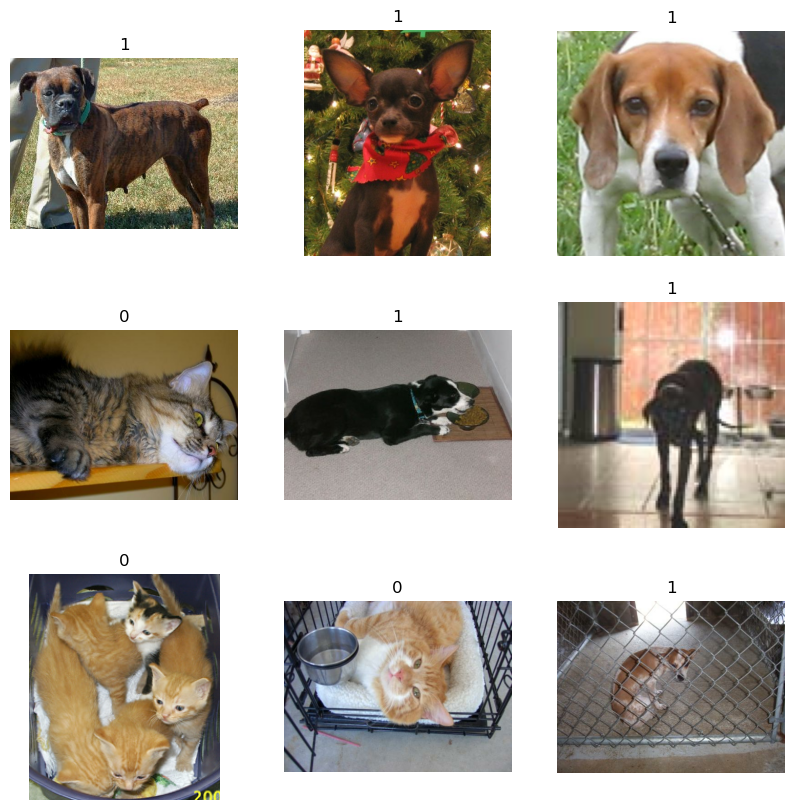

In [3]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [4]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

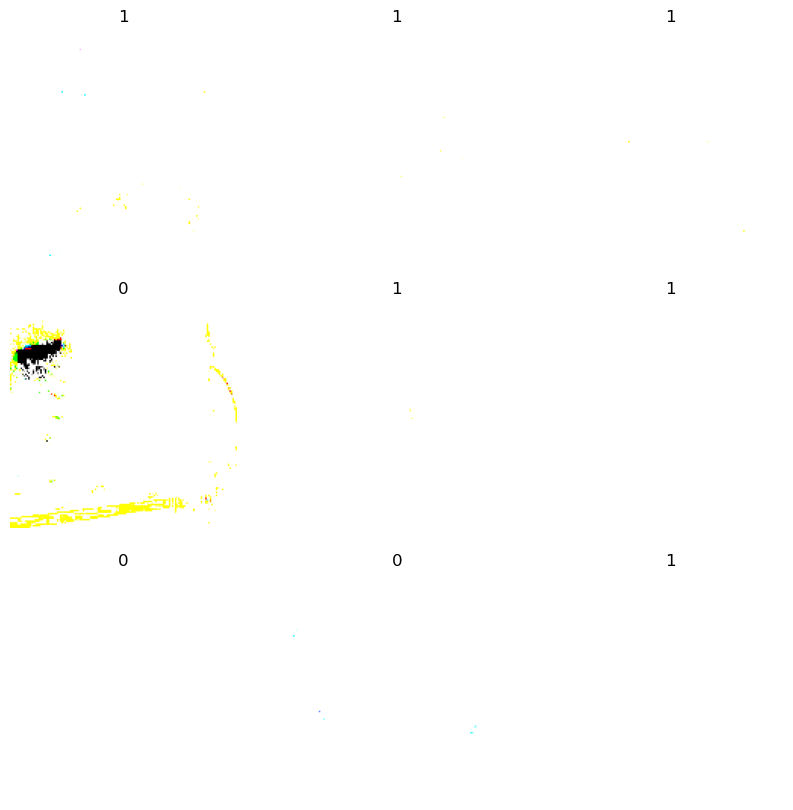

In [5]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [6]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [7]:
from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

2025-06-25 21:28:46.049538: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


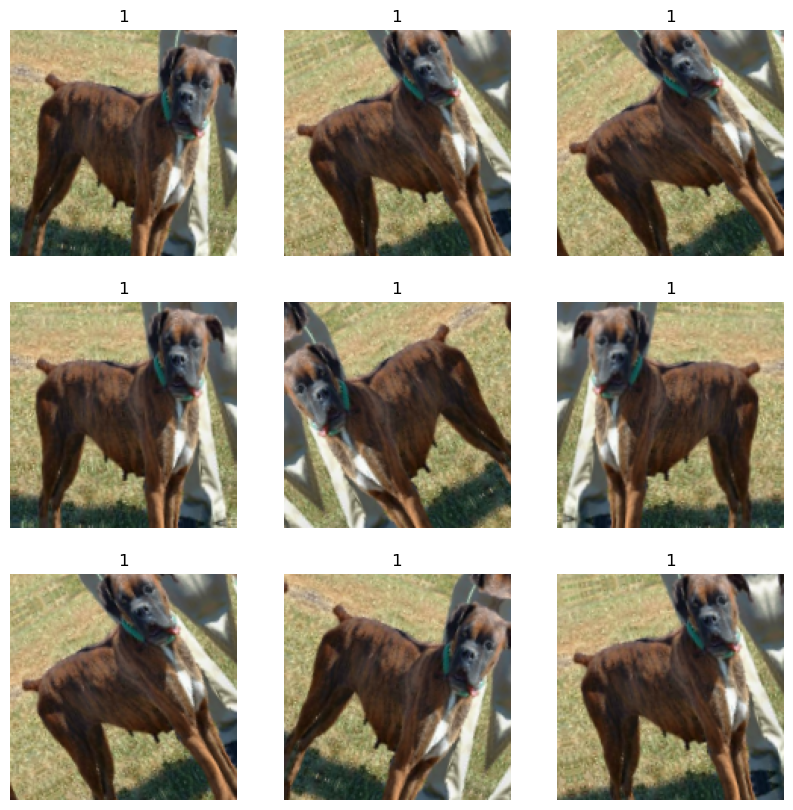

In [8]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")